In [153]:
import pandas as pd
import glob, json

export_files = glob.glob("data/telegram/**/result.json")

all_chats = []

for file in export_files:
    data = json.load(open(file))
    name = data["name"]
    df = pd.DataFrame(data["messages"])
    df["chat_name"] = name

    all_chats.append(df)

messages = pd.concat(all_chats).reset_index(drop=True)
messages["date"] = pd.to_datetime(messages["date"])
messages = messages[messages.type == "message"]
messages = messages[["date", "from", "text", "chat_name"]]
messages = messages[messages.text.str.len() > 0]
display(messages.chat_name.value_counts())
display(messages["from"].value_counts())
messages.head(3)


Karla    52852
David    15419
Fam      12875
Alex      3714
Name: chat_name, dtype: int64

Kyle Corbitt          32520
Karla Inostroza       32218
David Corbitt          8589
Christina Corbitt      3090
Jacqueline Corbitt     2703
Karen Corbitt          2531
Alex Chung             2226
Scott Corbitt           731
Alex Swan               178
Ashleigh Schafer         30
Yoda Corbitt             23
Morris Corbitt           10
Darwin Rios               8
Cowboy Corbitt            3
Name: from, dtype: int64

,date,from,text,chat_name
0,2018-07-15 17:03:54,Kyle Corbitt,Hi,Karla
1,2018-07-15 17:07:07,Karla Inostroza,Hi,Karla
2,2018-07-15 17:07:30,Karla Inostroza,Hdiejduejej,Karla


In [154]:
# Find all messages that have the `text` field as an array
# and convert them into a single string.

for i, row in messages[messages.text.apply(lambda x: isinstance(x, list))].iterrows():
    text_fragments = [(x["text"] if isinstance(x, dict) else x) for x in row["text"]]
    messages.loc[i, "text"] = "".join(text_fragments)


<AxesSubplot: >

False    84797
True        63
Name: truncated, dtype: int64

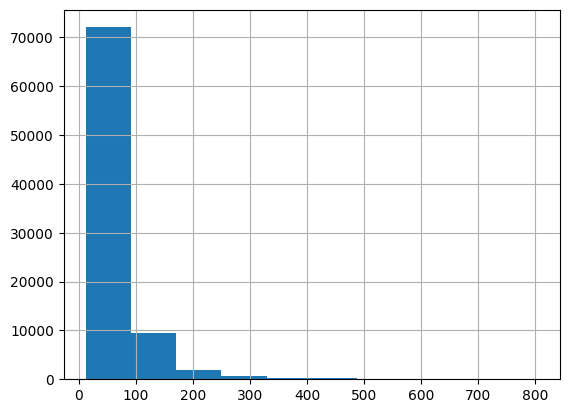

In [155]:
messages["text"] = messages.text.astype(str)
messages["formatted"] = (
    messages["from"].str.cat(messages["text"], sep=":\n").astype(str)
)

truncate_to = 800

messages["truncated"] = False
messages.loc[messages["formatted"].str.len() > truncate_to, "truncated"] = True
messages.loc[messages["formatted"].str.len() > truncate_to, "formatted"] = (
    messages["formatted"].str[:truncate_to] + "..."
)

display(messages["formatted"].str.len().hist())
display(messages["truncated"].value_counts())


Max history entries for Alex: 26
Max history entries for David: 26
Max history entries for Fam: 28
Max history entries for Karla: 34


<AxesSubplot: >

[{'chat_history': 'Alex Chung:\n'
                  'On my to listen list!\n'
                  '\n'
                  'Alex Chung:\n'
                  'Crypto.com put on a 10:30am meeting for me. Let’s start '
                  'today around 11:30!\n'
                  '\n'
                  'Kyle Corbitt:\n'
                  'Ok, can do',
  'chat_history_complete': True,
  'chat_name': 'Alex',
  'date': Timestamp('2022-04-12 23:00:24'),
  'formatted': 'Alex Chung:\nPut some comments on the contract',
  'from': 'Alex Chung',
  'text': 'Put some comments on the contract',
  'truncated': False}]


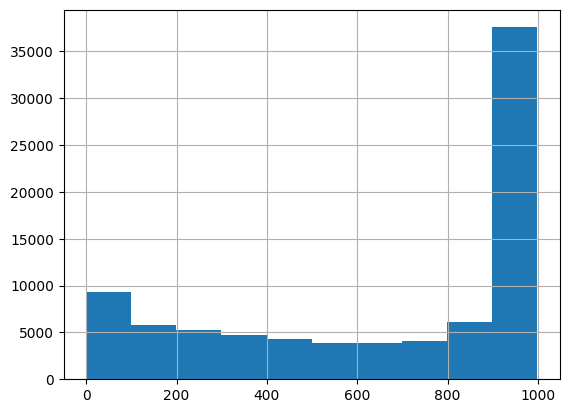

In [176]:
import pprint

messages["chat_history_complete"] = False
messages["chat_history"] = ""

# Populate the `chat_history` column with the previous messages in the conversation

for name, group in messages.groupby("chat_name"):
    group = group.sort_values("date")

    i = 0
    while not group["chat_history_complete"].all() and i < 100:
        i += 1
        history_i = group.shift(i)

        augmented_history = history_i["formatted"] + "\n\n" + group["chat_history"]

        # Messages more than 6 hours apart are probably not part of the same conversation
        too_old = (group["date"] - history_i["date"]) > pd.Timedelta("6 hours")

        # Don't add a message to the history if it would cause the history to be over 1000 characters
        too_long = augmented_history.str.len() > 1000

        # Mark the history as complete if adding another message would break one of the former conditions
        group["chat_history_complete"] = (
            group.chat_history_complete | too_old | too_long | history_i["date"].isna()
        )

        group.loc[~group["chat_history_complete"], "chat_history"] = augmented_history

    # Save the group back to the messages dataframe
    messages.loc[group.index] = group
    print(f"Max history entries for {name}: {i}")

messages["chat_history"] = messages["chat_history"].str[:-2]

display(messages["chat_history"].str.len().hist())
pprint.pprint(messages[messages.chat_name == "Alex"].sample(1).to_dict("records"))

del messages["chat_history_complete"]


In [177]:
# Remove messages that don't have any history or that are truncated

ds_df = messages[(messages.chat_history.str.len() > 0) & ~messages.truncated].copy()

display(ds_df.shape)
ds_df.sample(3)


(80507, 7)

,date,from,text,chat_name,formatted,truncated,chat_history
8490,2019-01-25 12:46:49,Kyle Corbitt,just feels kinda cruel if you could use a vacc...,Karla,Kyle Corbitt:\njust feels kinda cruel if you c...,False,Kyle Corbitt:\nI think my younger siblings wer...
92232,2022-07-24 23:54:53,Christina Corbitt,Successful pool party! Thanks for the wishes e...,Fam,Christina Corbitt:\nSuccessful pool party! Tha...,False,Karen Corbitt:\nThere are several things in th...
26071,2019-12-01 11:43:39,Kyle Corbitt,And copies for Erika,Karla,Kyle Corbitt:\nAnd copies for Erika,False,Kyle Corbitt:\nYep\n\nKyle Corbitt:\nOk\n\nKar...


In [178]:
def format_prompt(row):
    return f"""Respond to chat as {row["from"]}:

Recent messages:

{row["chat_history"]}

{row["from"]}:
"""


ds_df["prompt"] = ds_df.apply(format_prompt, axis=1)

ds_df.prompt.str.len().describe()

print(ds_df[ds_df.chat_name == "Alex"].iloc[1950].prompt)


Respond to chat as Alex Chung:

Recent messages:

Alex Chung:
There’s a heat wave in the Bay Area today. Ill be on mobile for my morning dog walk as I’ll be joining our sync first 30 min

Kyle Corbitt:
to check my understanding, you'll still be on at 7:30 but you'll be on a walk?

Alex Chung:
Yeah

Alex Chung:



In [179]:
# Let's just train on messages sent by Kyle for now
ds_df = ds_df[ds_df["from"] == "Kyle Corbitt"]

ds_df.shape


(31338, 8)

In [211]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "google/flan-t5-base"

# Load tokenizer of FLAN-t5-base
tokenizer = AutoTokenizer.from_pretrained(model_id)

prompt_lengths = ds_df.prompt.apply(tokenizer.encode).map(len)
display(prompt_lengths.describe())
max_prompt_length = prompt_lengths.max()

label_lengths = ds_df.text.apply(tokenizer.encode).map(len)
display(label_lengths.describe())
max_label_length = label_lengths.max()


count    31141.000000
mean       233.732603
std        104.071001
min         25.000000
25%        146.000000
50%        267.000000
75%        314.000000
max        511.000000
Name: prompt, dtype: float64

count    31141.000000
mean        11.766546
std         11.332799
min          2.000000
25%          5.000000
50%          8.000000
75%         15.000000
max        100.000000
Name: text, dtype: float64

In [212]:
# Let's just drop the longest prompts and completions for now. There aren't that many anyway.

ds_df = ds_df[label_lengths <= 100]
max_target_length = 100

ds_df = ds_df[prompt_lengths <= 512]
max_prompt_length = 512


In [220]:
import datasets

train_frac = 0.98

# Take the first train_frac of the df for training and the rest for test.
# Split by date so the model can't cheat on the test set (can still cheat
# on the training set I guess).

ds_df = ds_df[["prompt", "text"]]

train_ds = datasets.Dataset.from_pandas(ds_df.iloc[: int(len(ds_df) * train_frac)], preserve_index=False)
test_ds = datasets.Dataset.from_pandas(ds_df.iloc[int(len(ds_df) * train_frac) :], preserve_index=False)

ds = datasets.DatasetDict({"train": train_ds, "test": test_ds})

ds


DatasetDict({
    train: Dataset({
        features: ['prompt', 'text'],
        num_rows: 30518
    })
    test: Dataset({
        features: ['prompt', 'text'],
        num_rows: 623
    })
})

In [222]:
def preprocess(sample):
    inputs = tokenizer(
        sample["prompt"],
        max_length=max_prompt_length,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        sample["text"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True,
    )

    # Replace padding token with -100 so that loss in padding is ignored. TODO: might be
    # possible to do this automatically in the tokenizer config?
    input_tokens = [
        [(-100 if token == tokenizer.pad_token_id else token) for token in label]
        for label in labels["input_ids"]
    ]

    inputs["labels"] = input_tokens

    return inputs


tokenized_ds = ds.map(preprocess, batched=True, batch_size=1000)
tokenized_ds


  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30518
    })
    test: Dataset({
        features: ['prompt', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 623
    })
})

In [228]:
tokenized_ds.save_to_disk("data/chat_history")

Saving the dataset (0/1 shards):   0%|          | 0/30518 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/623 [00:00<?, ? examples/s]